In [1]:
! conda info --envs

# conda environments:
#
base                     C:\Users\bhave\anaconda3
lipnet_v1                C:\Users\bhave\anaconda3\envs\lipnet_v1
py39-tf210-env           C:\Users\bhave\anaconda3\envs\py39-tf210-env
pytorch_env              C:\Users\bhave\anaconda3\envs\pytorch_env
pytorch_env_assign       C:\Users\bhave\anaconda3\envs\pytorch_env_assign
tensorflow-assign-env  *  C:\Users\bhave\anaconda3\envs\tensorflow-assign-env
tf-gpu                   C:\Users\bhave\anaconda3\envs\tf-gpu



In [2]:
! pip install tensorflow==2.10.0 

In [3]:
! pip install matplotlib

In [4]:
! pip install pandas

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [2]:
data = pd.read_csv('Spike.csv')

In [3]:
data.head()

,-1.41E+00
0,-4.190
1,-2.240
2,-0.472
3,-2.490
4,0.784


In [4]:
full_data = data

In [5]:
data = data[:3000]

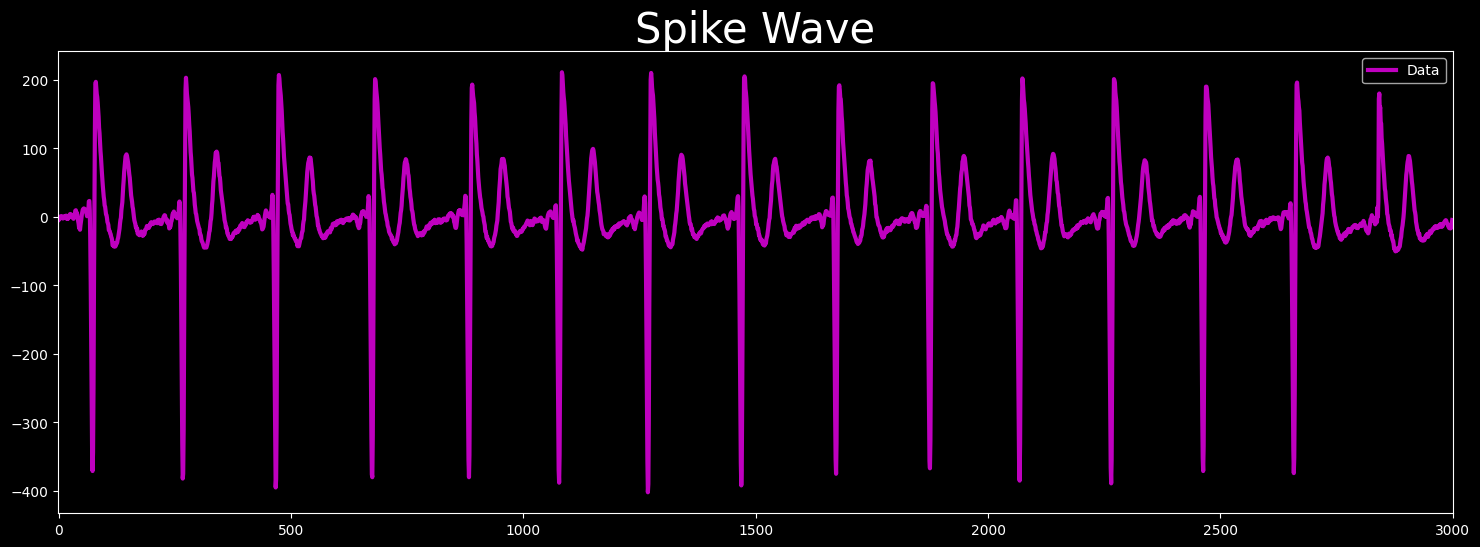

In [6]:
plt.figure(figsize=(18,6))
plt.xlim(-2,len(data))
plt.plot(data, 'm', lw =3, label = 'Data')
plt.title('Spike Wave', fontsize = 30)
plt.legend()
plt.show()

In [15]:
# Split data into X and y
T = 50
X = []
Y = []
for t in range(len(data) - T):
    x = data.iloc[t:t+T]  # Select rows using iloc
    X.append(x.values)    # Append values as a numpy array
    y = data.iloc[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1)  # Reshape to N x T x D
y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "y.shape", y.shape)

X.shape (2950, 50, 1) y.shape (2950, 1)


In [16]:
X_train = X[:-N//2]
y_train = y[:-N//2]
X_test  = X[-N//2:]
y_test  = y[-N//2:]

In [17]:
# Convert your numpy arrays to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [18]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate scheduler function
def lr_scheduler(epoch):
    if epoch < 150:
        return 0.001
    else:
        return 0.0001

In [19]:
lr_callback = LearningRateScheduler(lr_scheduler)

In [21]:
# Define your model architecture
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    lstm1 = LSTM(1024, return_sequences=True)(inputs)
    lstm2 = LSTM(1024)(lstm1)
    outputs = Dense(1)(lstm2)
    model = Model(inputs, outputs)
    return model

# Create the model
model = create_model(input_shape=(T, 1))

# Compile the model

model.compile(loss='mae', optimizer=Adam()) # Use l1 loss and try witg tgat

# Print model summary
model.summary()

# Train the model
hist = model.fit(X_train_tensor, y_train_tensor, epochs=200, validation_data=(X_test_tensor, y_test_tensor), callbacks=[lr_callback])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 1024)          4202496   
                                                                 
 lstm_5 (LSTM)               (None, 1024)              8392704   
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 12,596,225
Trainable params: 12,596,225
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
47/47 [==============================] - 7s 97ms/step - loss: 24.9031 - val_loss: 17.4632 - lr: 0.0010
Epoch 2/200
47/47 [==============================] - 4s 77ms/ste

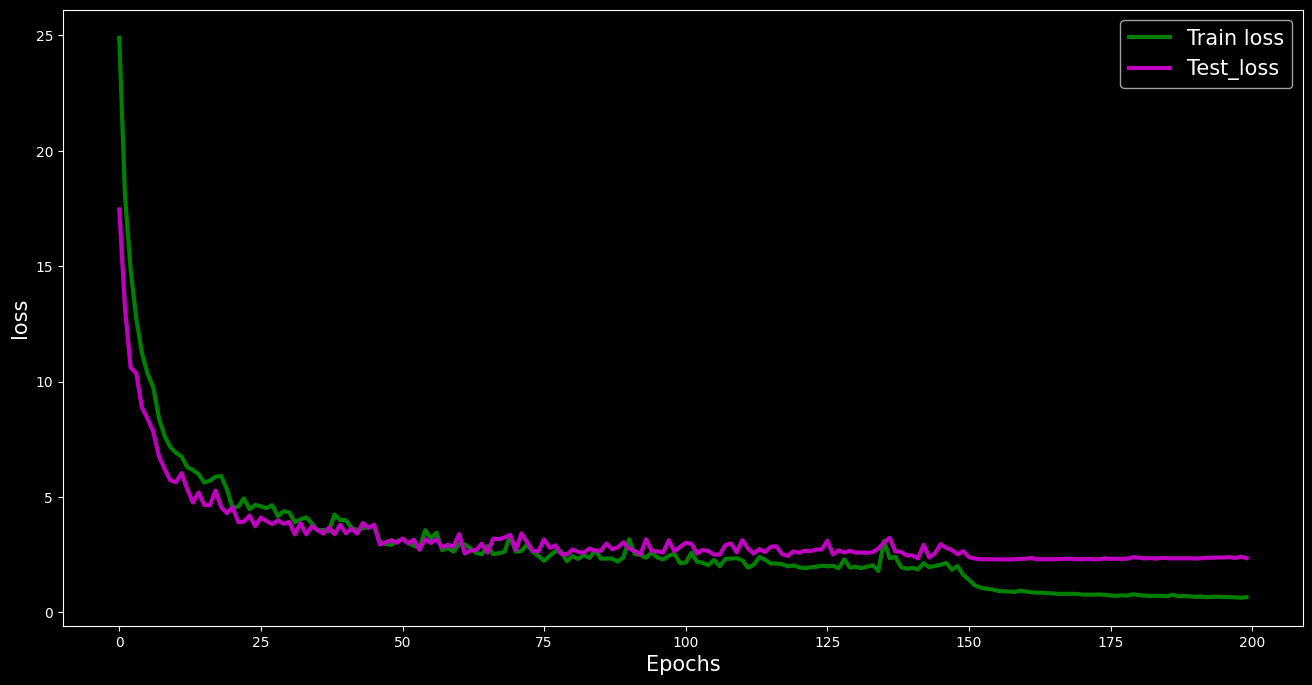

In [22]:
plt.figure(figsize = (16, 8))
plt.plot(hist.history['loss'],'g', lw = 3,  label='Train loss')
plt.plot(hist.history['val_loss'],'m', lw = 3, label='Test_loss')
plt.legend(fontsize = 15)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.show()

In [23]:
ypred = []

# First input for test
last_x = X_test_tensor[0]

while len(ypred) < len(y_test_tensor):
    p = model.predict(tf.reshape(last_x, (1, -1)))[0, 0]          

    # Update the predictions list
    ypred.append(p)
  
    # Make the new testing input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

1/1 [==============================] - 0s 58ms/step


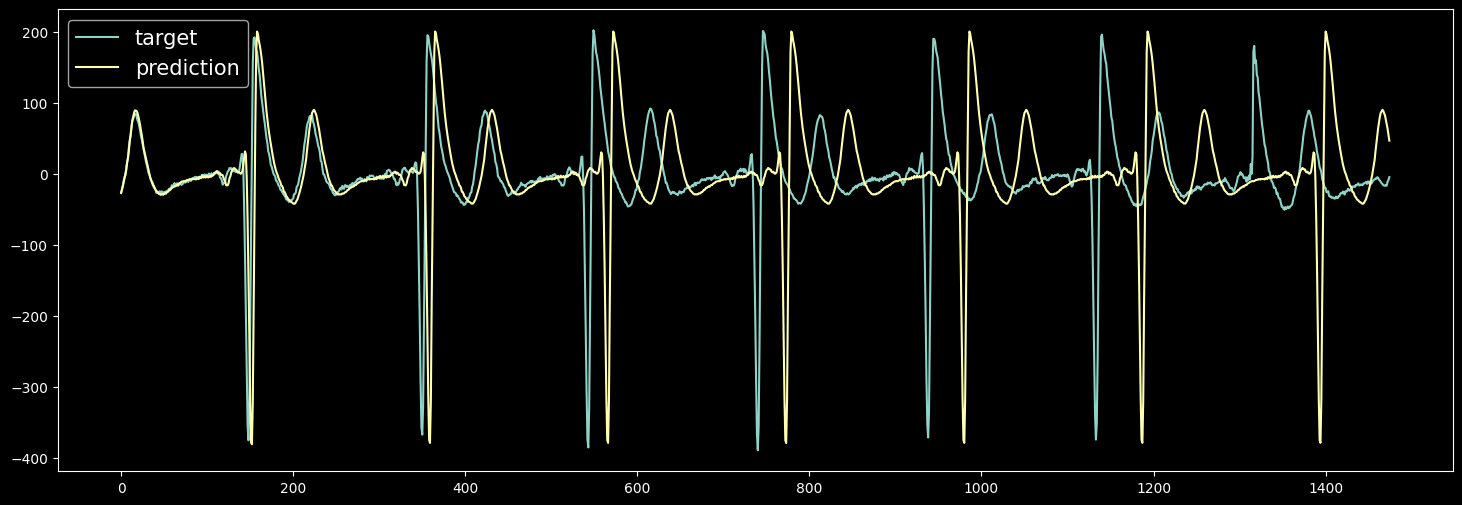

In [25]:
import matplotlib.pyplot as plt

# Create a figure and set its size
plt.figure(figsize=(18, 6))

# Plot the target values
plt.plot(y_test_tensor, label='target')

# Plot the predicted values
plt.plot(ypred, label='prediction')

# Add a legend
plt.legend(fontsize=15)

# Show the plot
plt.show()


In [174]:

# Assuming full_data is a DataFrame containing your data
# Obtain the values from the DataFrame
X_full_array = full_data.values

# Calculate the number of data points to pad
remaining_points = len(X_full_array) % 30
if remaining_points != 0:
    # Pad the array to make its length divisible by 10
    X_full_array = np.pad(X_full_array, ((0, 30 - remaining_points), (0, 0)), mode='constant', constant_values=0)

# Reshape the padded array into shape (-1, 10, 1)
X_full = X_full_array.reshape(-1, 30, 1)

# Make predictions on the full dataset
ypred_full = []

# First input for the full dataset
last_x_full = X_full[0]

while len(ypred_full) < len(full_data):
    p_full = model.predict(tf.reshape(last_x_full, (1, -1)))[0, 0]          

    # Update the predictions list
    ypred_full.append(p_full)
  
    # Make the new input for the full dataset
    last_x_full = np.roll(last_x_full, -1)
    last_x_full[-1] = p_full

# Add the predictions to the full_data DataFrame
full_data['predicted_values'] = ypred_full

# Print or inspect the updated DataFrame
print(full_data)

1/1 [==============================] - 0s 20ms/step
      -1.41E+00  predicted_values
0        -4.190         -0.247526
1        -2.240         -1.706113
2        -0.472         -2.370145
3        -2.490          2.550576
4         0.784          4.924671
...         ...               ...
4994    -34.500        -22.089621
4995    -35.700        -19.860842
4996    -37.100        -18.075544
4997    -38.100        -18.509947
4998    -40.700        -16.258785

[4999 rows x 2 columns]


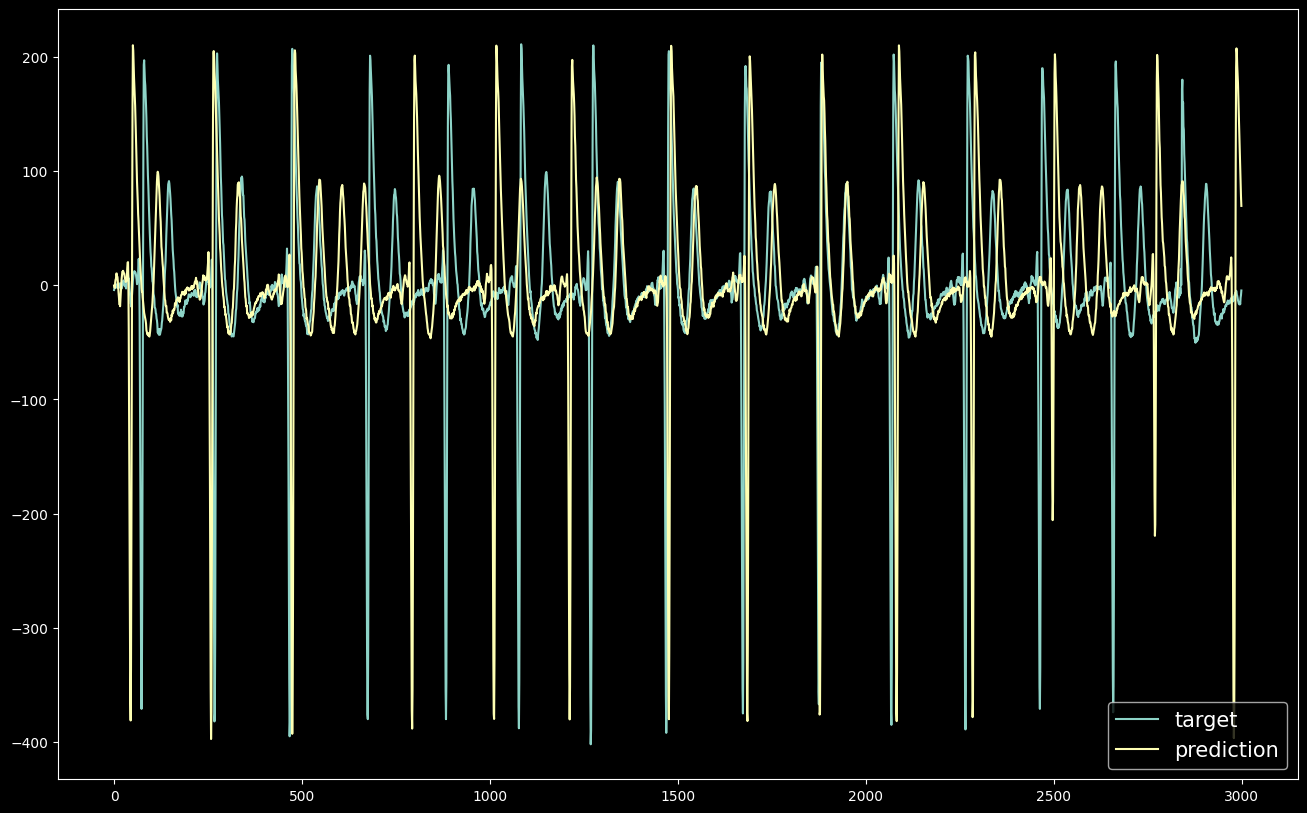

In [176]:
import matplotlib.pyplot as plt

# Create a figure and set its size
plt.figure(figsize=(16, 10))

# Plot the target values
plt.plot(data, label='target')

# Plot the predicted values
plt.plot(ypred_full[:3000], label='prediction')

# Add a legend
plt.legend(fontsize=15)

# Show the plot
plt.show()


### Part 2

In [ ]:
data = pd.read_csv('Heterogeneous_accelerometer_HAR.csv')
data.head